<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/%E4%BF%AE%E6%AD%A3%E6%A8%A1%E7%B5%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/skywalker0803r/c620.git
!pip install autorch > log.txt
!pip install optuna > log.txt

fatal: destination path 'c620' already exists and is not an empty directory.


# import

In [2]:
from c620.FV2 import AllSystem
from c620.configV2 import config
import joblib
import numpy as np
import pandas as pd
import os
os.chdir('/content/c620')
print(os.getcwd())
!git pull

/content/c620
Already up to date.


# data

In [3]:
demo = joblib.load('data/demo(real_data).pkl')
print(demo.keys())
icg_input = demo['icg_input']
c620_feed = demo['c620_feed']
t651_feed = demo['t651_feed']
print(icg_input.shape)
icg_input.head()

dict_keys(['icg_input', 'c620_feed', 't651_feed', 'c620_op', 'c660_op', 'c670_op', 'c620_wt', 'c660_wt', 'c670_wt'])
(168, 17)


,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC
2021-02-13,182.727005,2.060,11.670,37.270,17.901134,2.370,68.700,21.000,98.045372,0.6650,43.532,42.478,87.140,838.0,0.0,29.0,40.842743
2021-02-05,179.608627,2.165,12.377,38.074,18.646059,3.088,66.645,22.216,96.942879,0.7025,43.370,42.201,85.878,800.0,0.0,16.0,40.885593
2020-12-04,166.107956,2.151,12.047,37.287,19.038383,3.474,65.729,19.557,99.873688,0.6486,43.878,42.602,86.102,805.0,0.0,35.0,39.059292
2020-11-26,169.727284,1.360,12.000,37.630,18.240871,3.000,66.560,21.430,92.989864,0.6610,43.786,41.398,86.390,749.0,0.0,19.0,41.073098
2020-11-16,176.370055,1.837,11.857,37.198,17.663765,2.622,66.132,21.395,98.291358,0.5919,44.655,42.658,92.836,738.0,0.0,32.0,43.761401


In [4]:
f = joblib.load('/content/c620/model/allsystem.pkl')

In [5]:
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f.inference(demo['icg_input'],demo['c620_feed'],demo['t651_feed'])

In [6]:
c620_op_col = demo['c620_op'].dropna(axis=1).columns
f.c670_M.show_metrics(c620_op[c620_op_col],demo['c620_op'][c620_op_col])

,R2,MSE,MAPE
Density_Feed Properties,0,4.96996e-05,0.679799
Density_Vent Gas Production Rate and Composition,0,4.28281e-05,1.32113
Density_Distillate Production Rate and Composition,0,0.00477864,8.79057
Density_Sidedraw Production Rate and Composition,0,3.14098e-06,0.137242
Density_Bottoms Production Rate and Composition,0,6.75192e-06,0.283144
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0,510.82,15.4566
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0,245.08,8.65935
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0,156.074,6.37836
AVG,0,113.997,5.21327


In [7]:
c660_op_col = demo['c660_op'].dropna(axis=1).columns
f.c670_M.show_metrics(c660_op[c660_op_col],demo['c660_op'][c660_op_col])

,R2,MSE,MAPE
Density_Feed Properties,0,4.06317e-07,0.0549908
Density_Vent Gas Production Rate and Composition,0,0.00102259,5.38411
Density_Distillate (Benzene Drag) Production Rate and Composition,0,0.000161959,1.32394
Density_Sidedraw (Benzene )Production Rate and Composition,0,1.63593e-06,0.144719
Density_Bottoms Production Rate and Composition,0,5.35808e-08,0.0251665
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0,1522.34,22.255
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0,1.29308,1.04193
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0,2.23056,1.28032
AVG,0,190.733,3.93878


In [8]:
c670_op_col = demo['c670_op'].dropna(axis=1).columns
f.c670_M.show_metrics(c670_op[c670_op_col],demo['c670_op'][c670_op_col])

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0,2.08057e-08,0.0160399
Density_Bottoms Production Rate and Composition,0,1.41321e-05,0.423287
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0,3499,18.0255
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0,1.52393,0.419802
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0,8.79471,1.18714
AVG,0,701.864,4.01436


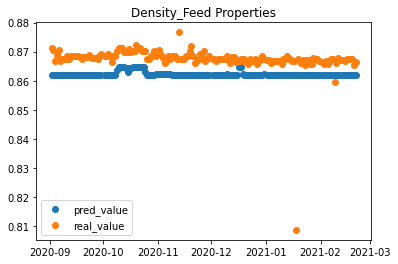

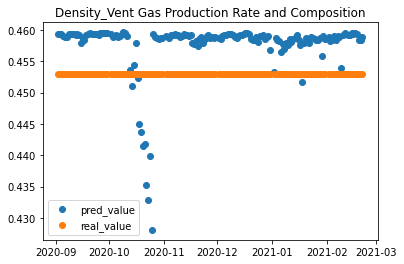

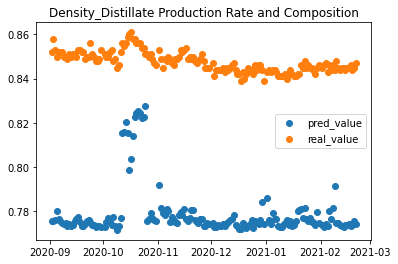

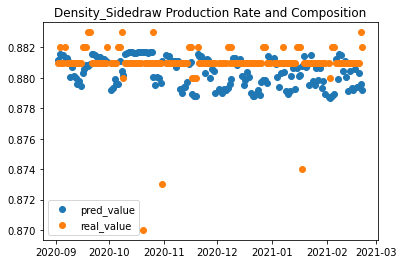

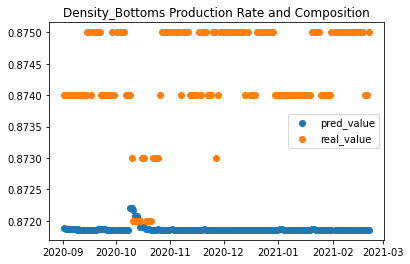

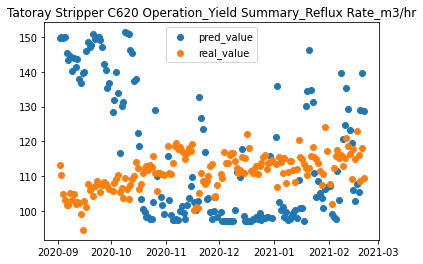

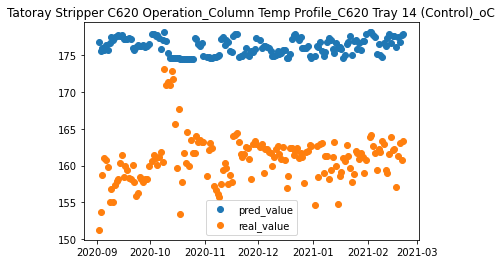

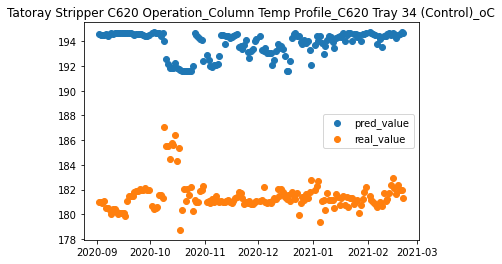

In [10]:
import matplotlib.pyplot as plt

for i in c620_op_col:
  idx = demo['icg_input'].index
  plt.scatter(idx,c620_op[i],label='pred_value')
  plt.scatter(idx,demo['c620_op'][i],label='real_value')
  plt.title(i)
  plt.legend()
  plt.show()

In [11]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader,TensorDataset
from torch.optim import Adam

In [12]:
in_dim = len(icg_input.columns)+len(c620_feed.columns)+len(t651_feed.columns)
out_dim = len(c620_op_col)+len(c660_op_col)+len(c670_op_col)
fix_model = nn.Sequential(
    nn.Linear(out_dim,256),nn.ReLU(),
    nn.Linear(256,256),nn.ReLU(),
    nn.Linear(256,out_dim),nn.Identity()
    )
optimizer = Adam(fix_model.parameters(),lr=1e-3)

In [13]:
def train(model,optimizer,epochs=100):
  history = []
  for e in range(epochs):
    c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f.inference(demo['icg_input'],demo['c620_feed'],demo['t651_feed'])
    y_pred = torch.cat((torch.FloatTensor(c620_op[c620_op_col].values),torch.FloatTensor(c660_op[c660_op_col].values),torch.FloatTensor(c670_op[c670_op_col].values)),dim=1).detach()
    y_pred_fix = fix_model(y_pred)
    y_real = torch.cat((torch.FloatTensor(demo['c620_op'][c620_op_col].values),torch.FloatTensor(demo['c660_op'][c660_op_col].values),torch.FloatTensor(demo['c670_op'][c670_op_col].values)),dim=1)
    loss = (y_pred_fix - y_real)**2
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if e % 10 == 0:
      print(f'ep:{e} loss{loss.item()}')
    history.append(loss.item())
  return model,history

In [14]:
fix_model,history = train(fix_model,optimizer,epochs=300)

ep:0 loss12347.90234375
ep:10 loss918.5512084960938
ep:30 loss325.624267578125
ep:40 loss61.44606399536133
ep:50 loss29.624757766723633
ep:60 loss30.1527042388916
ep:70 loss27.088787078857422
ep:80 loss24.996145248413086
ep:90 loss23.55040168762207
ep:100 loss22.47130012512207
ep:110 loss21.545734405517578
ep:120 loss20.674583435058594
ep:130 loss19.835725784301758
ep:140 loss19.03238296508789
ep:150 loss18.281875610351562
ep:160 loss17.58905029296875
ep:170 loss16.996562957763672
ep:180 loss16.548477172851562
ep:190 loss16.202116012573242
ep:200 loss15.940963745117188
ep:210 loss15.741621017456055
ep:220 loss15.580775260925293
ep:230 loss15.443977355957031
ep:240 loss15.324028015136719
ep:250 loss15.21733283996582
ep:260 loss15.119221687316895
ep:270 loss15.027786254882812
ep:280 loss14.941679000854492
ep:290 loss14.860127449035645


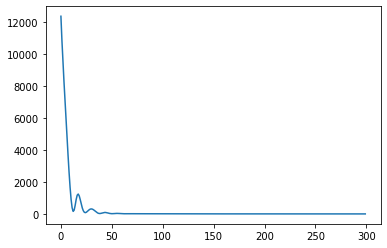

In [15]:
import matplotlib.pyplot as plt

plt.plot(history)

In [16]:
c620_wt,c620_op,c660_wt,c660_op,c670_wt,c670_op = f.inference(demo['icg_input'],demo['c620_feed'],demo['t651_feed'])

In [17]:
op_pred = fix_model(torch.cat((torch.FloatTensor(c620_op[c620_op_col].values),torch.FloatTensor(c660_op[c660_op_col].values),torch.FloatTensor(c670_op[c670_op_col].values)),dim=1))
op_pred = pd.DataFrame(op_pred.detach().numpy(),index=demo['icg_input'].index)
c620_op = op_pred.iloc[:,:8]
c660_op = op_pred.iloc[:,8:16]
c670_op = op_pred.iloc[:,-5:]
c620_op.columns = c620_op_col
c660_op.columns = c660_op_col
c670_op.columns = c670_op_col

In [18]:
f.c670_M.show_metrics(c620_op[c620_op_col],demo['c620_op'][c620_op_col])

,R2,MSE,MAPE
Density_Feed Properties,0.00250206,0.344469,104.404
Density_Vent Gas Production Rate and Composition,0,0.00810331,10.3146
Density_Distillate Production Rate and Composition,0,0.0700748,13.4718
Density_Sidedraw Production Rate and Composition,0.000398226,0.0785913,21.8103
Density_Bottoms Production Rate and Composition,0,0.0654413,13.2596
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0,22.8363,3.29203
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0,12.1525,1.45445
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0,5.46862,0.733861
AVG,0.000362536,5.12802,21.0926


,R2,MSE,MAPE
Density_Feed Properties,0.00250206,0.344469,104.404
Density_Vent Gas Production Rate and Composition,0,0.00810331,10.3146
Density_Distillate Production Rate and Composition,0,0.0700748,13.4718
Density_Sidedraw Production Rate and Composition,0.000398226,0.0785913,21.8103
Density_Bottoms Production Rate and Composition,0,0.0654413,13.2596
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0,22.8363,3.29203
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0,12.1525,1.45445
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0,5.46862,0.733861
AVG,0.000362536,5.12802,21.0926


In [20]:
f.c670_M.show_metrics(c660_op[c660_op_col],demo['c660_op'][c660_op_col])

,R2,MSE,MAPE
Density_Feed Properties,0,0.0433502,22.7968
Density_Vent Gas Production Rate and Composition,0,0.0657068,67.6889
Density_Distillate (Benzene Drag) Production Rate and Composition,0,0.15085,97.4706
Density_Sidedraw (Benzene )Production Rate and Composition,0,0.0147532,11.9742
Density_Bottoms Production Rate and Composition,0,0.0207036,9.30236
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0,99.3251,6.46497
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0,1.01929,0.821802
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.1855,1.92075,0.98181
AVG,0.0231875,12.8201,27.1877


In [21]:
f.c670_M.show_metrics(c670_op[c670_op_col],demo['c670_op'][c670_op_col])

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0,0.0468864,13.5511
Density_Bottoms Production Rate and Composition,0,0.0948074,61.1813
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0,151.622,3.52121
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0,5.14631,0.693745
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0,9.93265,0.887006
AVG,0,33.3686,15.9669


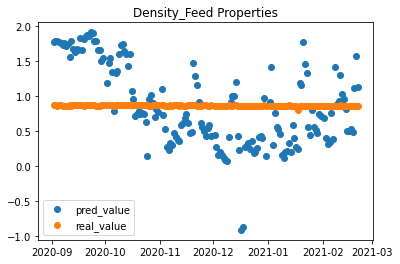

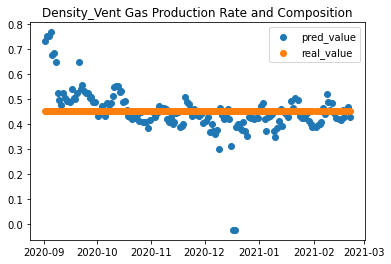

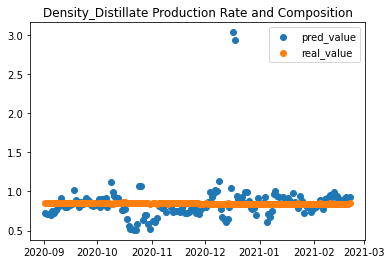

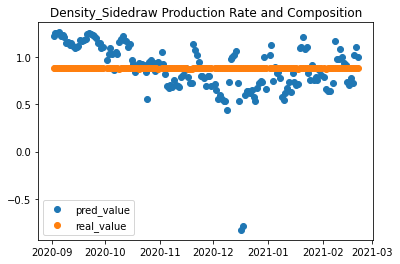

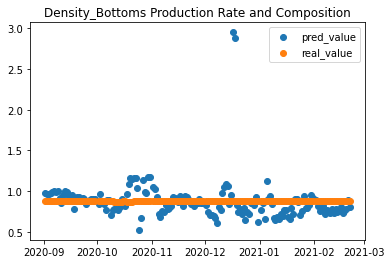

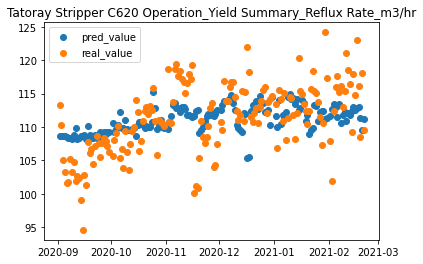

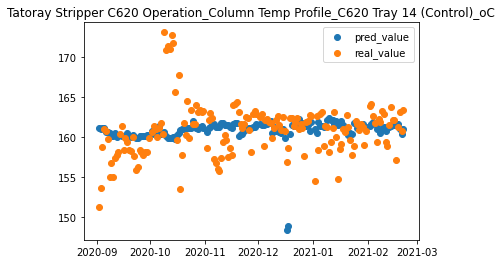

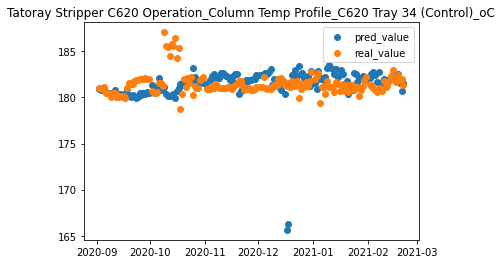

In [22]:
for i in c620_op_col:
  idx = demo['icg_input'].index
  plt.scatter(idx,c620_op[i],label='pred_value')
  plt.scatter(idx,demo['c620_op'][i],label='real_value')
  plt.title(i)
  plt.legend()
  plt.show()

In [23]:
import joblib

In [24]:
joblib.dump(fix_model,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/fix_model.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/fix_model.pkl']